# Coral Triangle Mini Project

This project is based on McManus et al. (2020) Global Change Biology

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import geopandas as gpd
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import os
from shapely.geometry import Point
import scipy.stats as st
from tqdm import tqdm


Bad key text.latex.preview in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default qualit

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Load relevant files

In [3]:
Dij = np.load("data/data/Data_Dij_2083_ave.npy") # mean connectivity matrix from 1960-2007
DHW_00 = np.load("data/data/DHW_00.npy") # hindcast degree heating weeks
DHW_05 = np.load("data/data/DHW_05.npy") # 0.5 deg increase degree heating week time series
DHW_10 = np.load("data/data/DHW_10.npy") # 1.0 deg increase degree heating week time series
DHW_15 = np.load("data/data/DHW_15.npy") # 1.5 deg increase degree heating week time series
DHW_20 = np.load("data/data/DHW_20.npy") # 2.0 deg increase degree heating week time series
areas = np.load("data/data/AREA_sites_2083.npy") # areas for all sites (m²)
lats = np.load("data/data/Data_Lat_wholeCT_2083.npy") # latitudes for all sites
lons = np.load("data/data/Data_Lon_wholeCT_2083.npy") # longitudes for all sites
tst = np.load("data/data/TST_sites_2083_rev.npy") # thermal stress thresholds for all sites

# Functions

In [53]:
def Lisa(y, t, pars):
    C = y[0]
    A = y[1]
    F = 1 - C - A
    
    r = pars['r']
    delta = pars['delta']
    eta = pars['eta']
    areas = pars['areas']
    DHW = pars['DHW']
    D = pars['D']
    f = pars['f']
    mu = pars['mu']
    gamma = pars['gamma']
    a = pars['a']
    phi = pars['phi']
    g0 = pars['g0']
    g1 = pars['g1']
    
    growth = r*C*F
    if t % 53 == 14:
        dispersal = delta/areas * np.dot(D,C*areas*f)
    else:
        dispersal = 0
    bleach = eta * DHW * C
    natural_death = mu * C
    dCdt = growth + dispersal - bleach - natural_death
    
    dAdt = gamma*A*F + a*C*A + phi*F - (g0 + (g1 - g0)*C**2)*A
    
    if np.isnan(dCdt).any():
        ID = np.where(np.isnan(dCdt))
        dCdt[ID] = 1e-6
    if (dCdt+C < 1e-6).any():
        ID = np.where(dCdt+C < 1e-6)
        dCdt[ID] = 1e-6
    if np.isnan(dAdt).any():
        ID = np.where(np.isnan(dAdt))
        dAdt[ID] = 1e-6
    if (dAdt+A < 1e-6).any():
        ID = np.where(dAdt+A < 1e-6)
        dAdt[ID] = 1e-6
    return np.array([dCdt, dAdt])

In [5]:
def rungekutta4(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, y0.shape[0], y0.shape[1]))
    y[0] = y0
    for i in range(n - 1):
        args[0]['DHW'] = DHW[:,i]
        h = t[i+1] - t[i]
        # print(list(args)[-1])
        k1 = f(y[i], t[i], *args)
        # print(k1.shape)
        # print(y[i].shape)
        k2 = f(y[i] + k1 * h / 2., t[i] + h / 2., *args)
        # print(k2.shape)
        k3 = f(y[i] + k2 * h / 2., t[i] + h / 2., *args)
        # print(k3.shape)
        k4 = f(y[i] + k3 * h, t[i] + h, *args)
        y[i+1] = y[i] + (h / 6.) * (k1 + 2*k2 + 2*k3 + k4)
        
    ID = np.where(y <= 0.);y[ID] = 1e-10
    ID = np.where(y > 1.);y[ID] = 1.0
    return y

In [7]:
def dNdt(N,D,DHW,P):
    
    dt = P['dt']
    r = P['r']
    beta = P['beta']
    eta= P['eta']
    areas = P['areas']
    
    #! Calculate the derivative
    growth = r*N*(1-N)
    dispersal = (beta/areas * np.dot(D,N*areas))*(1-N)
    bleaching = eta * DHW * N
    dN = (growth + dispersal - bleaching) * dt
    
    #! Prevent NaN or population values below 1e-6 in output
    if np.isnan(dN).any():
        ID = np.where(np.isnan(dNdt))
        dN[ID] = 1e-6
    if (dN+N < 1e-6).any():
        ID = np.where(dN+N < 1e-6)
        dN[ID] = 1e-6
    # if (dN+N > 1.0).any():
    #     ID = np.where(dN+N > 1.0)
    #     dN[ID] = 1.0
    
    return dN

In [8]:
def RK2(N0,D,DHW,P): #2nd-order Runge-Kutta
    
    N = N0
    dN1 = dNdt(N0,D,DHW,P)
    
    N1 = N + 0.5*dN1
    dN2 = dNdt(N1,D,DHW,P)
    
    dNave = (dN1 + dN2)/2
    
    N = N0 + dNave
    
    ID = np.where(N <= 0.);N[ID] = 1e-10
    ID = np.where(N > 1.);N[ID] = 1.0
    
    return N

In [9]:
def run_model(INIT_N,D,DHW,P):
   
    timepoints = P['timepoints']
    
    N_array = np.zeros((D.shape[0],len(timepoints)))
    
    N_array[:,0] = INIT_N
    
    for i in np.arange(0,len(timepoints)-1):
        N_array[:,i+1] = RK2(N_array[:,i],D,DHW[:,i],P)
    
    return N_array

# Set the parameters

In [10]:
# Set the DHW time series
DHW = DHW_20

# Set the other parameters
numyears = 2054-2007
dt = 1 # approximately daily time step
numweeks = DHW.shape[1]
timepoints = np.arange(0,numweeks)
time_array = np.linspace(0,47,int(numyears/dt)) # for plotting
r = 1.0/52 # growth rate
beta = 0.1/52 # fecundity
eta = 0.1/52 # links DHW to bleaching mortality
D = Dij

pars = {}
pars['r'] = 0.2/52
pars['delta'] = 0.01
pars['eta'] = 0.1
pars['areas'] = areas
#pars['DHW'] = DHW_05
pars['D'] = Dij
pars['f'] = 10
pars['mu'] = 0.02/52
pars['gamma'] = 1/52
pars['a'] = 0.2/52
pars['phi'] = 0.01/52
pars['g0'] = 0.2/52
pars['g1'] = 0.8/52

parameters = {'dt':dt,
              'timepoints':timepoints,
              'r':r,
              'beta':beta,
              'eta':eta,
              'areas':areas
             }

# Set initial conditions
initial_cover = 1.0
N0_array = np.ones(2083)*initial_cover

C0 = np.ones(2083)*0.99
A0 = np.ones(2083)*0.01

# Run the model

In [54]:
DHW = DHW_00
# pars['eta'] = 0
N_all_00 = rungekutta4(Lisa, np.array([C0, A0]), timepoints, args=(pars,))
N_all_00 = N_all_00[:,0,:]

# pars['eta'] = 0.1
DHW = DHW_05

N_all_05 = rungekutta4(Lisa, np.array([C0, A0]), timepoints, args=(pars,))
N_all_05 = N_all_05[:,0,:]

DHW = DHW_10

N_all_10 = rungekutta4(Lisa, np.array([C0, A0]), timepoints, args=(pars,))
N_all_10 = N_all_10[:,0,:]

DHW = DHW_15

N_all_15 = rungekutta4(Lisa, np.array([C0, A0]), timepoints, args=(pars,))
N_all_15 = N_all_15[:,0,:]

DHW = DHW_20

N_all_20 = rungekutta4(Lisa, np.array([C0, A0]), timepoints, args=(pars,))
N_all_20 = N_all_20[:,0,:]

In [11]:
DHW = DHW_00
N_all_00 = run_model(N0_array,D,DHW,parameters).T

DHW = DHW_05
N_all_05 = run_model(N0_array,D,DHW,parameters).T

DHW = DHW_10 
N_all_10 = run_model(N0_array,D,DHW,parameters).T

DHW = DHW_15
N_all_15 = run_model(N0_array,D,DHW,parameters).T

DHW = DHW_20 
N_all_20 = run_model(N0_array,D,DHW,parameters).T

# Plot the results

## Code for plotting time series

In [28]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

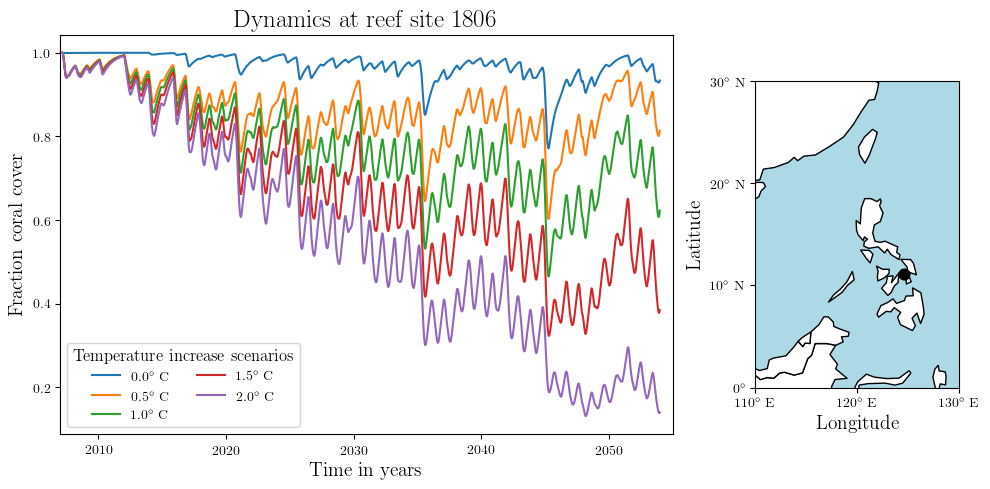

In [54]:
start = 2007
stop = 2054
time = np.linspace(start,stop,numweeks)
reef = 1806
fig, ax = plt.subplots(1, 2, figsize=(10,5), gridspec_kw={'width_ratios': (3, 1)})
ax[0].plot(time, N_all_00[:,reef], label=r'0.0$^\circ$ C')
ax[0].plot(time, N_all_05[:,reef], label=r'0.5$^\circ$ C')
ax[0].plot(time, N_all_10[:,reef], label=r'1.0$^\circ$ C')
ax[0].plot(time, N_all_15[:,reef], label=r'1.5$^\circ$ C')
ax[0].plot(time, N_all_20[:,reef], label=r'2.0$^\circ$ C')
ax[0].set_title('Dynamics at reef site '+ str(reef), fontsize = 18)
ax[0].set_xlabel('Time in years', fontsize = 14)
ax[0].set_ylabel('Fraction coral cover', fontsize = 14)
lgd = ax[0].legend(title = 'Temperature increase scenarios', ncol = 2)
lgd.get_title().set_fontsize(12)
ax[0].set_xlim(2007, 2055)

world.plot(facecolor = 'white', edgecolor = 'black', ax = ax[1])
ax[1].scatter(lons[reef], lats[reef], s = 60, facecolor = 'black', marker = 'o')
ax[1].set_xlim(110, 130)
ax[1].set_ylim(0, 30)
ax[1].set_xlabel('Longitude', fontsize = 14)
ax[1].set_ylabel('Latitude', fontsize = 14)
ax[1].set_xticks([110, 120, 130])
ax[1].set_xticklabels([r'110$^\circ$ E', r'120$^\circ$ E', r'130$^\circ$ E'])
ax[1].set_yticks([0, 10, 20, 30])
ax[1].set_yticklabels([r'0$^\circ$', r'10$^\circ$ N', r'20$^\circ$ N', r'30$^\circ$ N'])
ax[1].patch.set_color('lightblue')

plt.tight_layout()
plt.savefig(f'Plots/Reef_{reef}_dynamics.png', dpi = 300, bbox_inches = 'tight')
plt.show()

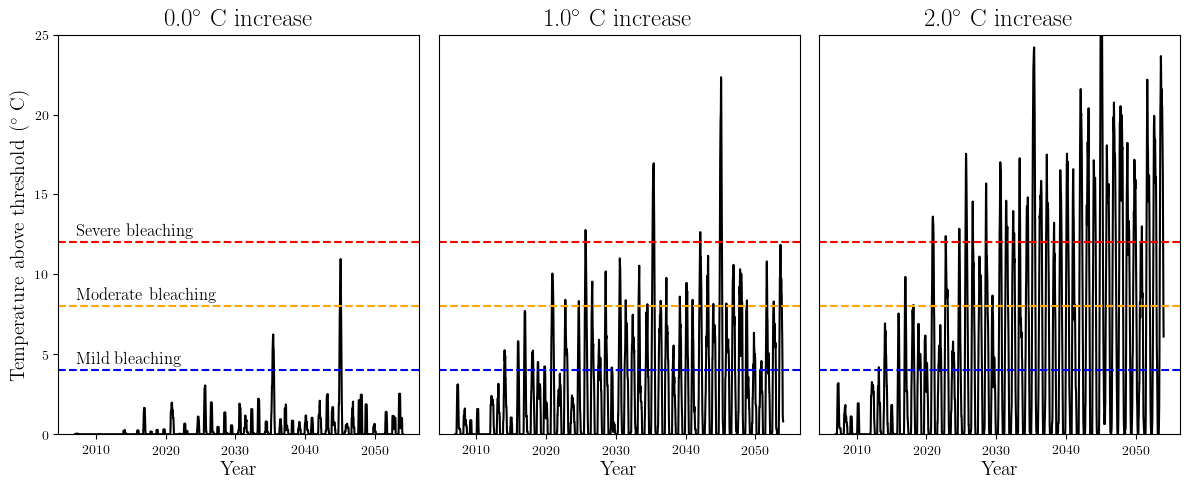

In [27]:
# plt.plot(DHW_00[0,:])
# plt.plot(DHW_05[0,:])
# plt.plot(DHW_10[0,:])
# plt.plot(DHW_15[0,:])
fig, ax = plt.subplots(1, 3, figsize = (12,5))

ax[0].plot(time, DHW_00[1806,:], color = 'black')
ax[0].axhline(4, ls = '--', color = 'blue')
ax[0].axhline(8, ls = '--', color = 'orange')
ax[0].axhline(12, ls = '--', color = 'red')
ax[0].set_ylabel(r'Temperature above threshold ($^\circ$ C)', fontsize = 14)
ax[0].set_xlabel('Year', fontsize = 14)
ax[0].set_ylim(0, 25)
ax[0].set_title(r'0.0$^\circ$ C increase', fontsize = 18)
ax[0].text(2007.2, 12.5, 'Severe bleaching', fontsize = 12)
ax[0].text(2007.2, 8.5, 'Moderate bleaching', fontsize = 12)
ax[0].text(2007.2, 4.5, 'Mild bleaching', fontsize = 12)

ax[1].plot(time, DHW_10[1806,:], color = 'black')
ax[1].axhline(4, ls = '--', color = 'blue')
ax[1].axhline(8, ls = '--', color = 'orange')
ax[1].axhline(12, ls = '--', color = 'red')
ax[1].set_yticks([])
ax[1].set_ylim(0, 25)
ax[1].set_title(r'1.0$^\circ$ C increase', fontsize = 18)
ax[1].set_xlabel('Year', fontsize = 14)

ax[2].plot(time, DHW_20[1806,:], color = 'black')
ax[2].axhline(4, ls = '--', color = 'blue')
ax[2].axhline(8, ls = '--', color = 'orange')
ax[2].axhline(12, ls = '--', color = 'red')
ax[2].set_yticks([])
ax[2].set_ylim(0, 25)
ax[2].set_title(r'2.0$^\circ$ C increase', fontsize = 18)
ax[2].set_xlabel('Year', fontsize = 14)

plt.tight_layout()
plt.savefig('Plots/bleaching_occurence.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [63]:
N_all_05[-1,reef], N_all_10[-1,reef],N_all_15[-1,reef],N_all_20[-1,reef]

(0.8137933389934809,
 0.6223499694672391,
 0.3841055837616795,
 0.1390183757638669)

In [64]:
df_05 = pd.DataFrame(N_all_05).T
df_05['Threshold'] = tst
df_05['Areas'] = areas
df_10 = pd.DataFrame(N_all_10).T
df_10['Threshold'] = tst
df_10['Areas'] = areas
df_15 = pd.DataFrame(N_all_15).T
df_15['Threshold'] = tst
df_15['Areas'] = areas
df_20 = pd.DataFrame(N_all_20).T
df_20['Threshold'] = tst
df_20['Areas'] = areas

df_05.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2528,2529,2530,2531,2532,2533,2534,2535,Threshold,Areas
0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.962139,0.962875,0.963598,0.964307,0.965003,0.965686,0.966257,0.966220,30.355384,9.096884e+07
1,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.966675,0.967311,0.967935,0.968547,0.969149,0.969739,0.970317,0.970296,31.550169,1.598306e+08
2,1.0,0.999691,0.999407,0.999146,0.998906,0.998994,0.999075,0.999149,0.999217,0.999280,...,0.999957,0.999960,0.999963,0.999966,0.999969,0.999972,0.999974,0.999976,30.034533,3.860803e+06
3,1.0,0.999973,0.999947,0.999921,0.999896,0.999899,0.999901,0.999903,0.999905,0.999907,...,0.994539,0.994654,0.994768,0.994878,0.994987,0.995093,0.995196,0.995298,30.125342,1.447490e+08
4,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.995651,0.995752,0.995850,0.995947,0.996041,0.996132,0.996222,0.996310,29.687736,1.017326e+08
5,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.997436,0.997499,0.997560,0.997621,0.997679,0.997737,0.997792,0.997847,29.376711,1.205058e+08
6,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.999984,0.999985,0.999985,0.999986,0.999987,0.999987,0.999988,0.999988,29.319286,3.218750e+07
7,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.987778,0.988027,0.988270,0.988509,0.988743,0.988972,0.989196,0.989416,28.772938,6.776460e+08
8,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.987556,0.987804,0.988048,0.988286,0.988520,0.988750,0.988975,0.989195,28.538812,8.655498e+08
9,1.0,0.999747,0.999499,0.999256,0.999018,0.999038,0.999057,0.999076,0.999094,0.999112,...,0.983393,0.983721,0.984042,0.984356,0.984665,0.984967,0.985264,0.985555,28.493230,9.304865e+08


In [65]:
df_05_th = df_05.sort_values('Threshold').reset_index(drop = True)
df_10_th = df_10.sort_values('Threshold').reset_index(drop = True)
df_15_th = df_15.sort_values('Threshold').reset_index(drop = True)
df_20_th = df_20.sort_values('Threshold').reset_index(drop = True)

df_05_ar = df_05.sort_values('Areas').reset_index(drop = True)
df_10_ar = df_10.sort_values('Areas').reset_index(drop = True)
df_15_ar = df_15.sort_values('Areas').reset_index(drop = True)
df_20_ar = df_20.sort_values('Areas').reset_index(drop = True)

In [66]:
len(N_all_05[:,0])#/47

2536

In [67]:
N_all_05.T.shape

(2083, 2536)

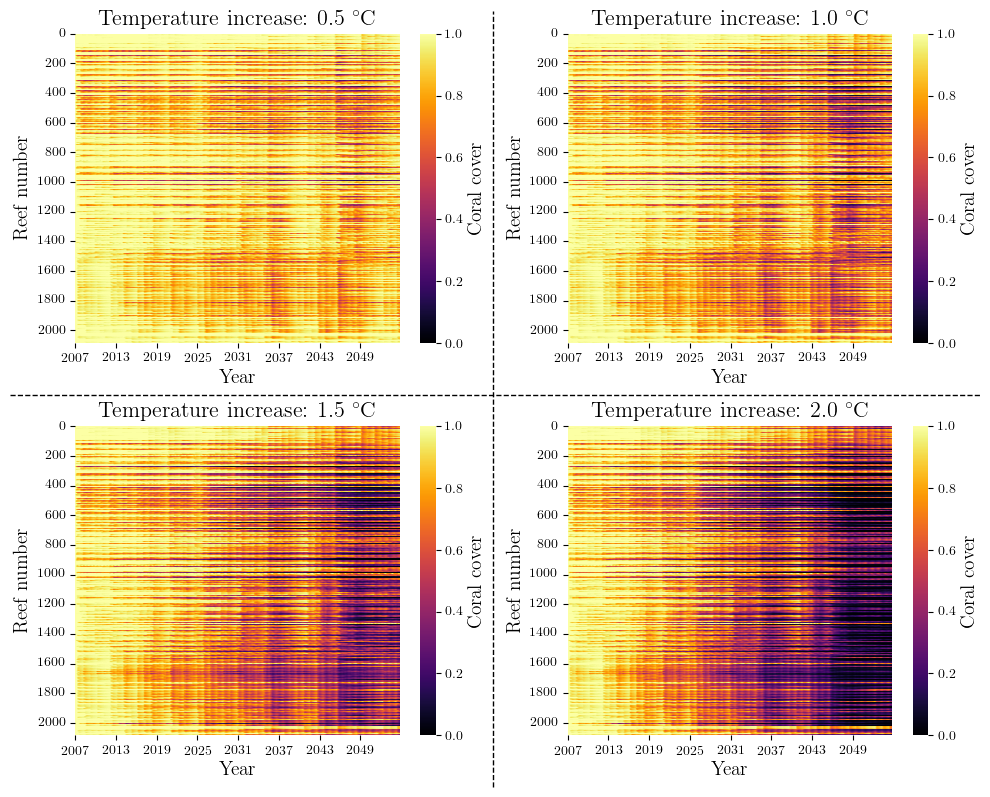

In [68]:
fig, axs = plt.subplots(2, 2, figsize = (10, 8))
ax = axs.flatten()

htmp = sns.heatmap(N_all_05.T, cmap = 'inferno', vmin = 0, vmax = 1, ax = ax[0],
                  cbar_kws={'label': 'Coral cover'})
ax[0].figure.axes[-1].yaxis.label.set_size(14)
ax[0].set_xticks([(318)*i for i in range(8)], labels = [2007 + (6*i) for i in range(8)],
                rotation = 0, fontsize = 10)
ax[0].set_xlabel('Year', fontsize = 14)
ax[0].set_yticks([200*i for i in range(11)], labels = [200*i for i in range(11)],
                 fontsize = 10)
ax[0].set_ylabel('Reef number', fontsize = 14)
ax[0].set_title(r'Temperature increase: 0.5 $^\circ$C', fontsize = 16)

htmp = sns.heatmap(N_all_10.T, cmap = 'inferno', vmin = 0, vmax = 1, ax = ax[1],
                  cbar_kws={'label': 'Coral cover'})
ax[1].figure.axes[-1].yaxis.label.set_size(14)
ax[1].set_xticks([(318)*i for i in range(8)], labels = [2007 + (6*i) for i in range(8)],
                rotation = 0, fontsize = 10)
ax[1].set_xlabel('Year', fontsize = 14)
ax[1].set_yticks([200*i for i in range(11)], labels = [200*i for i in range(11)],
                 fontsize = 10)
ax[1].set_ylabel('Reef number', fontsize = 14)
ax[1].set_title(r'Temperature increase: 1.0 $^\circ$C', fontsize = 16)

htmp = sns.heatmap(N_all_15.T, cmap = 'inferno', vmin = 0, vmax = 1, ax = ax[2],
                  cbar_kws={'label': 'Coral cover'})
ax[2].figure.axes[-1].yaxis.label.set_size(14)
ax[2].set_xticks([(318)*i for i in range(8)], labels = [2007 + (6*i) for i in range(8)],
                rotation = 0, fontsize = 10)
ax[2].set_xlabel('Year', fontsize = 14)
ax[2].set_yticks([200*i for i in range(11)], labels = [200*i for i in range(11)],
                 fontsize = 10)
ax[2].set_ylabel('Reef number', fontsize = 14)
ax[2].set_title(r'Temperature increase: 1.5 $^\circ$C', fontsize = 16)

htmp = sns.heatmap(N_all_20.T, cmap = 'inferno', vmin = 0, vmax = 1, ax = ax[3],
                  cbar_kws={'label': 'Coral cover'})
ax[3].figure.axes[-1].yaxis.label.set_size(14)
ax[3].set_xticks([(318)*i for i in range(8)], labels = [2007 + (6*i) for i in range(8)],
                rotation = 0, fontsize = 10)
ax[3].set_xlabel('Year', fontsize = 14)
ax[3].set_yticks([200*i for i in range(11)], labels = [200*i for i in range(11)],
                 fontsize = 10)
ax[3].set_ylabel('Reef number', fontsize = 14)
ax[3].set_title(r'Temperature increase: 2.0 $^\circ$C', fontsize = 16)
# plt.colorbar(htmp)
fig.add_artist(mpl.lines.Line2D([0.493, 0.493], [0.01, 0.98], color = 'black', lw = 1, ls = '--'))
fig.add_artist(mpl.lines.Line2D([0.01, 0.98], [0.5, 0.5], color = 'black', lw = 1, ls = '--'))
plt.tight_layout()
# plt.savefig('Plots/Heatmap_populations.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [69]:
st.spearmanr(df_05_ar['Areas'], df_05_ar[2535])

SpearmanrResult(correlation=-0.0018817363705011855, pvalue=0.9316009424676484)

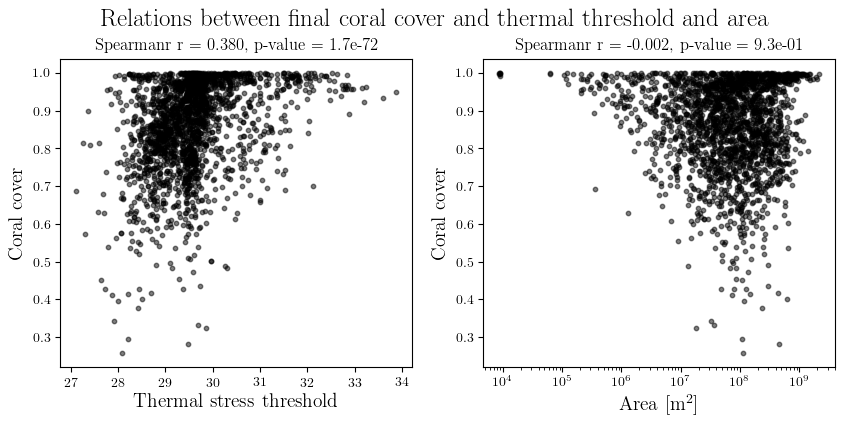

In [70]:
fig, ax = plt.subplots(1, 2, figsize = (10,4))

ax[0].scatter(df_05_ar['Threshold'], df_05_ar[2535], s = 10, facecolor = 'black', alpha = 0.5)
ax[0].set_xlabel('Thermal stress threshold', fontsize = 14)
ax[0].set_ylabel('Coral cover', fontsize = 14)
ax[0].set_title(f"Spearmanr r = {st.spearmanr(df_05_ar['Threshold'], df_05_ar[2535])[0]:.3f}, p-value = {st.spearmanr(df_05_ar['Threshold'], df_05_ar[2535])[1]:.1e}")

ax[1].scatter(df_05_ar['Areas'], df_05_ar[2535], s = 10, facecolor = 'black', alpha = 0.5)
ax[1].set_xscale('log')
ax[1].set_xlabel('Area [m$^2$]', fontsize = 14)
ax[1].set_ylabel('Coral cover', fontsize = 14)
ax[1].set_title(f"Spearmanr r = {st.spearmanr(df_05_ar['Areas'], df_05_ar[2535])[0]:.3f}, p-value = {st.spearmanr(df_05_ar['Areas'], df_05_ar[2535])[1]:.1e}")

fig.text(0.5, 0.96, 'Relations between final coral cover and thermal threshold and area',
        fontsize = 18, ha = 'center')
# plt.tight_layout()
# plt.savefig('Plots/Correlation.png', dpi = 300, bbox_inches = 'tight')
plt.show()

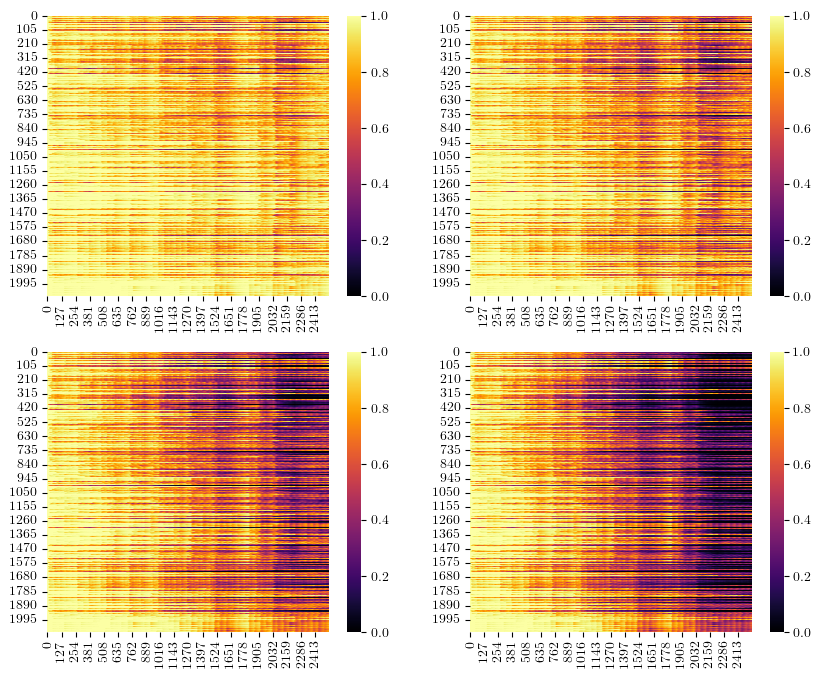

In [71]:
fig, axs = plt.subplots(2, 2, figsize = (10, 8))
ax = axs.flatten()

htmp = sns.heatmap(df_05_th, cmap = 'inferno', vmin = 0, vmax = 1, ax = ax[0])
htmp = sns.heatmap(df_10_th, cmap = 'inferno', vmin = 0, vmax = 1, ax = ax[1])
htmp = sns.heatmap(df_15_th, cmap = 'inferno', vmin = 0, vmax = 1, ax = ax[2])
htmp = sns.heatmap(df_20_th, cmap = 'inferno', vmin = 0, vmax = 1, ax = ax[3])
# plt.colorbar(htmp)
plt.show()

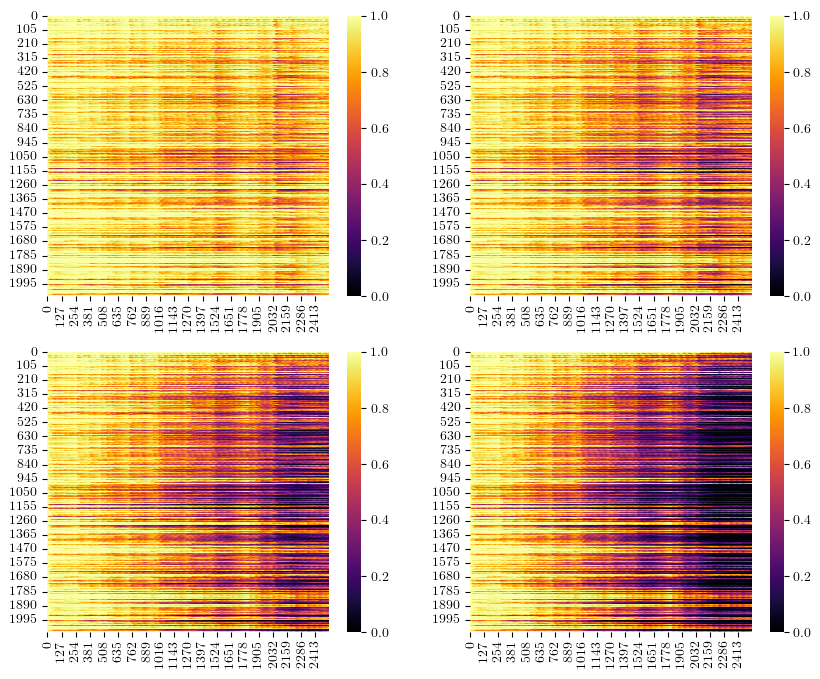

In [72]:
fig, axs = plt.subplots(2, 2, figsize = (10, 8))
ax = axs.flatten()

htmp = sns.heatmap(df_05_ar, cmap = 'inferno', vmin = 0, vmax = 1, ax = ax[0])
htmp = sns.heatmap(df_10_ar, cmap = 'inferno', vmin = 0, vmax = 1, ax = ax[1])
htmp = sns.heatmap(df_15_ar, cmap = 'inferno', vmin = 0, vmax = 1, ax = ax[2])
htmp = sns.heatmap(df_20_ar, cmap = 'inferno', vmin = 0, vmax = 1, ax = ax[3])
# plt.colorbar(htmp)
plt.show()

In [62]:
np.percentile(N_all_20[-1,:], 20)

0.014817034295121309

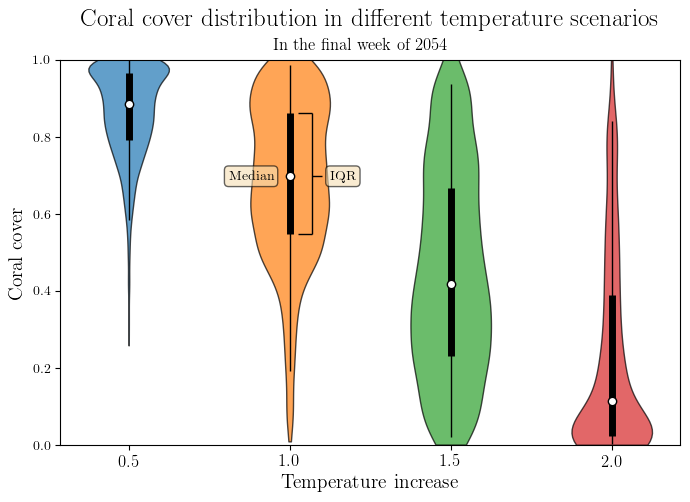

In [73]:
fig, ax = plt.subplots(figsize=(8,5))
parts = plt.violinplot(
        N_all_05[-1,:], showmeans=False, showmedians=False,
        showextrema=False, positions = [0])

for pc in parts['bodies']:
    pc.set_facecolor('C0')
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)
    
plt.vlines(0, np.percentile(N_all_05[-1,:], 25), np.percentile(N_all_05[-1,:], 75),
          lw = 5, color = 'black')
plt.vlines(0, np.percentile(N_all_05[-1,:], 2.5), np.percentile(N_all_05[-1,:], 97.5),
          lw = 1, color = 'black')
plt.scatter(0, np.median(N_all_05[-1,:]), edgecolor = 'black', facecolor = 'white',
           zorder = 4)

parts = plt.violinplot(
        N_all_10[-1,:], showmeans=False, showmedians=False,
        showextrema=False, positions = [1])

for pc in parts['bodies']:
    pc.set_facecolor('C1')
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)
    
plt.vlines(1, np.percentile(N_all_10[-1,:], 25), np.percentile(N_all_10[-1,:], 75),
          lw = 5, color = 'black')
plt.vlines(1, np.percentile(N_all_10[-1,:], 2.5), np.percentile(N_all_10[-1,:], 97.5),
          lw = 1, color = 'black')
plt.scatter(1, np.median(N_all_10[-1,:]), edgecolor = 'black', facecolor = 'white',
           zorder = 4)


parts = plt.violinplot(
        N_all_15[-1,:], showmeans=False, showmedians=False,
        showextrema=False, positions = [2])

for pc in parts['bodies']:
    pc.set_facecolor('C2')
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)
    
plt.vlines(2, np.percentile(N_all_15[-1,:], 25), np.percentile(N_all_15[-1,:], 75),
          lw = 5, color = 'black')
plt.vlines(2, np.percentile(N_all_15[-1,:], 2.5), np.percentile(N_all_15[-1,:], 97.5),
          lw = 1, color = 'black')
plt.scatter(2, np.median(N_all_15[-1,:]), edgecolor = 'black', facecolor = 'white',
           zorder = 4)


parts = plt.violinplot(
        N_all_20[-1,:], showmeans=False, showmedians=False,
        showextrema=False, positions = [3])

for pc in parts['bodies']:
    pc.set_facecolor('C3')
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)
    
plt.vlines(3, np.percentile(N_all_20[-1,:], 25), np.percentile(N_all_20[-1,:], 75),
          lw = 5, color = 'black')
plt.vlines(3, np.percentile(N_all_20[-1,:], 2.5), np.percentile(N_all_20[-1,:], 97.5),
          lw = 1, color = 'black')
plt.scatter(3, np.median(N_all_20[-1,:]), edgecolor = 'black', facecolor = 'white',
           zorder = 4)

plt.ylim(0, 1)
plt.xticks([0,1,2,3], labels = ['0.5', '1.0', '1.5', '2.0'], fontsize = 12)
plt.xlabel('Temperature increase', fontsize = 14)
plt.ylabel('Coral cover', fontsize = 14)
plt.title('Coral cover distribution in different temperature scenarios', fontsize = 18, pad = 24)
fig.text(0.5, 0.9, 'In the final week of 2054', fontsize = 12, ha = 'center')
plt.text(0.9, np.median(N_all_10[-1,:]), 'Median', ha = 'right', va = 'center',
         bbox = dict(boxstyle='round', facecolor='wheat', alpha=0.6))
plt.vlines(1.14, np.percentile(N_all_10[-1,:], 25), np.percentile(N_all_10[-1,:], 75),
          lw = 1, color = 'black')
plt.hlines(np.percentile(N_all_10[-1,:], 25), 1.05, 1.14,
          lw = 1, color = 'black')
plt.hlines(np.percentile(N_all_10[-1,:], 75), 1.05, 1.14,
          lw = 1, color = 'black')
plt.hlines(np.percentile(N_all_10[-1,:], 50), 1.14, 1.2,
          lw = 1, color = 'black')
plt.text(1.25, np.median(N_all_10[-1,:]), 'IQR', ha = 'left', va = 'center',
         bbox = dict(boxstyle='round', facecolor='wheat', alpha=0.6))
# plt.savefig('Plots/final_coral_cover_distribution.png', dpi = 300, bbox_inches = 'tight')
plt.show()

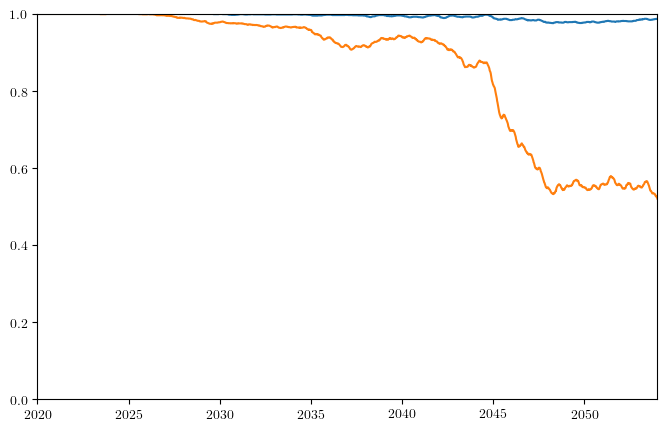

In [91]:
fig, ax = plt.subplots(figsize=(8,5))
survival_10 = []
survival_20 = []
for i in range(2536):
    survival_20.append(len(np.where(N_all_20[i,:] > 0.1)[0])/2083)
    survival_10.append(len(np.where(N_all_10[i,:] > 0.1)[0])/2083)
    
start = 2007
stop = 2054
time = np.linspace(start,stop,numweeks)
plt.plot(time, survival_10)
plt.plot(time, survival_20)
plt.ylim(0, 1)
plt.xlim(2020, 2054)
# plt.axvline(2023)
# plt.savefig('Plots/final_coral_cover_distribution.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [428]:
gdf_10 = gpd.GeoDataFrame({'Latitude': lats, 'Longitude': lons})
gdf_20 = gpd.GeoDataFrame({'Latitude': lats, 'Longitude': lons})

gdf_10['geometry'] = gdf_10.apply(lambda x: Point(x['Longitude'], x['Latitude']), axis = 1)
gdf_10['coral_cover'] = N_all_10[int(53*43),:]
gdf_10['Area'] = np.log10(areas)

gdf_20['geometry'] = gdf_20.apply(lambda x: Point(x['Longitude'], x['Latitude']), axis = 1)
gdf_20['coral_cover'] = N_all_20[int(53*43),:]
gdf_20['Area'] = np.log10(areas)

In [429]:
areas_code = []

for i in range(len(areas)):
    if areas[i] < 1e6:
        areas_code.append(5)
    elif 1e6 <= areas[i] < (5e3)**2:
        areas_code.append(10)
    elif (1e4)**2 > areas[i] >= (5e3)**2:
        areas_code.append(20)
    else:
        areas_code.append(25)

In [430]:
gdf_10['Area_code'] = areas_code

In [431]:
gdf.head(5)

,Latitude,Longitude,geometry,coral_cover,Area,Area_code
0,-14.258846,125.308304,POINT (125.30830 -14.25885),0.745994,7.958893,20
1,-14.302370,125.744177,POINT (125.74418 -14.30237),0.788381,8.203660,25
2,-19.798164,148.091009,POINT (148.09101 -19.79816),0.988176,6.586678,10
3,-19.954702,148.472597,POINT (148.47260 -19.95470),0.886637,8.160616,25
4,-20.086865,148.874704,POINT (148.87470 -20.08687),0.892671,8.007460,25


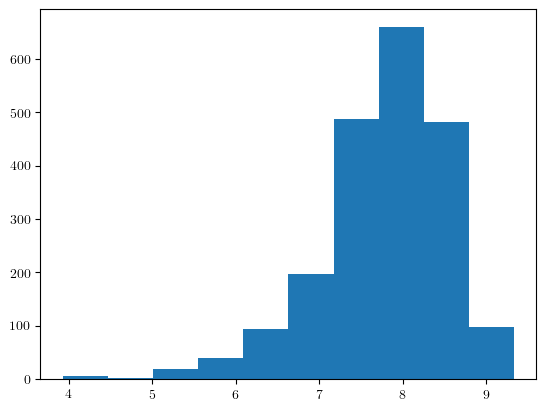

In [432]:
plt.hist(gdf_10['Area'])
# plt.xscale('log')
plt.show()

100%|██████████| 2083/2083 [10:33<00:00,  3.29it/s]


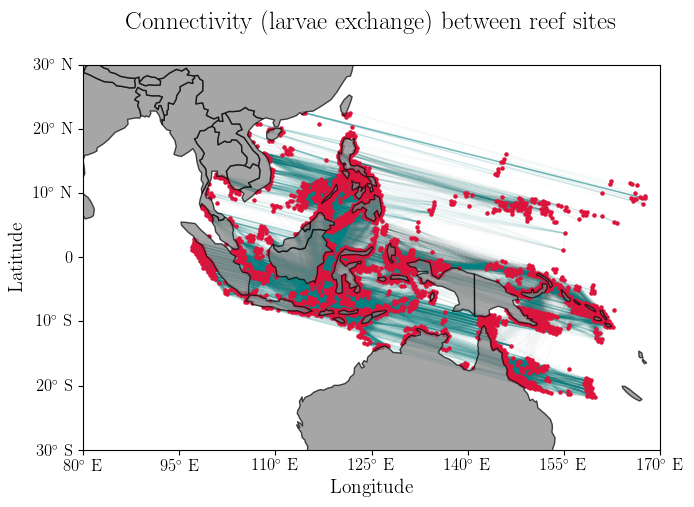

In [92]:
fig, ax = plt.subplots(figsize=(8,5))
for i in tqdm(range(2083)):
    for j in range(i+1):
        if Dij[i,j] != 0:
            plt.plot([lons[i], lons[j]], [lats[i], lats[j]], lw = 1,
                    alpha = Dij[i,j]/np.max(Dij), zorder = 0, color = 'teal')

plt.scatter(lons, lats, s = 5, color = 'crimson')
world.plot(ax = ax, facecolor = 'grey', edgecolor = 'black', alpha = 0.7)
plt.xlim(80, 170)
plt.ylim(-30, 30)
plt.yticks([-30, -20, -10, 0, 10, 20, 30], labels = [r'30$^\circ$ S', r'20$^\circ$ S', r'10$^\circ$ S',
                                                     '0', r'10$^\circ$ N', r'20$^\circ$ N',
                                                     r'30$^\circ$ N'], fontsize = 12)
plt.xticks([80, 95, 110, 125, 140, 155, 170], labels = [r'80$^\circ$ E', r'95$^\circ$ E', r'110$^\circ$ E',
                                                      r'125$^\circ$ E', r'140$^\circ$ E', r'155$^\circ$ E',
                                                        r'170$^\circ$ E'], fontsize = 12)
plt.xlabel('Longitude', fontsize = 14)
plt.ylabel('Latitude', fontsize = 14)
plt.title('Connectivity (larvae exchange) between reef sites', fontsize = 18, pad = 26)
plt.savefig('Plots/connectivity_reef_sites.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [21]:
connections = []

for i in range(2083):
    connections.append(len(np.where(Dij[i,:] != 0)[0]))

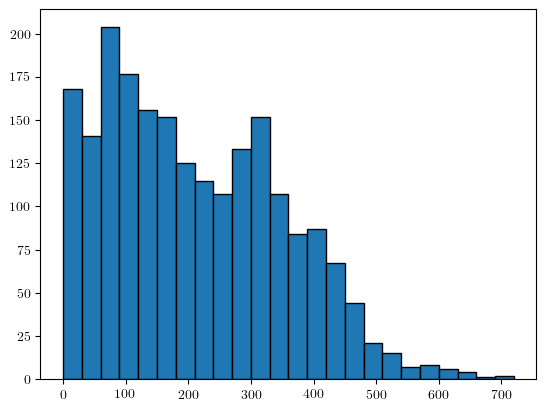

In [27]:
plt.hist(connections, bins = [30*i for i in range(25)], edgecolor = 'black')
plt.show()

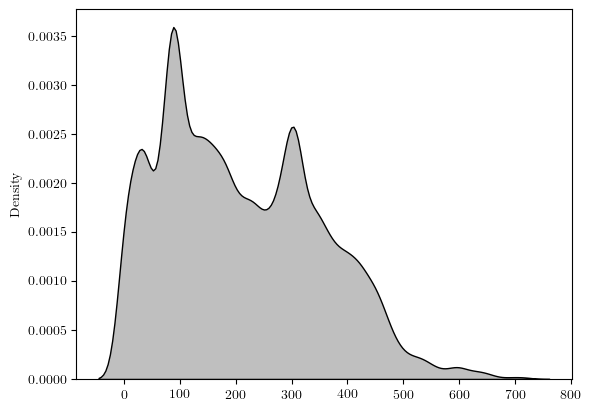

In [36]:
# plt.hist(connections, bins = [30*i for i in range(25)], edgecolor = 'black', density = True)
sns.kdeplot(connections, fill = True, bw_adjust = 0.5, color = 'black')
plt.show()

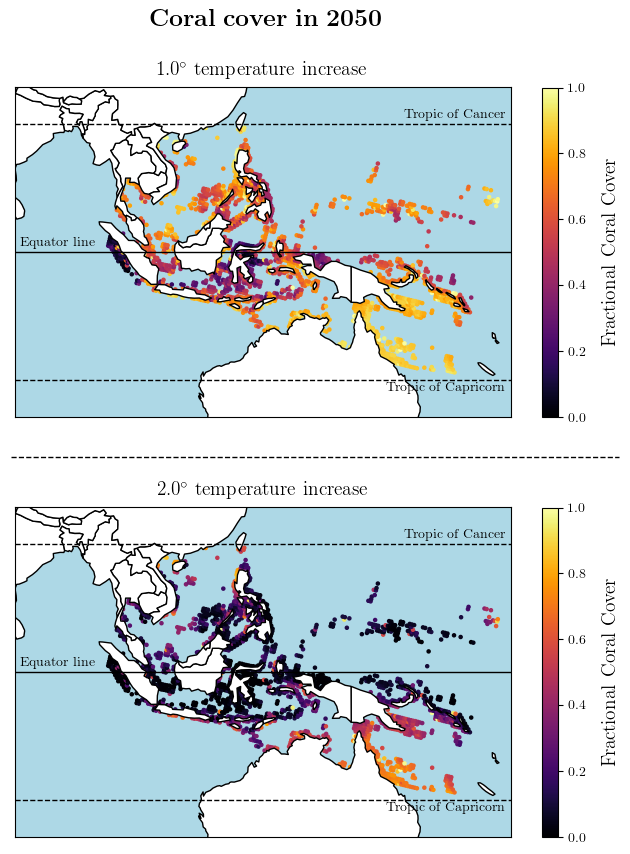

In [485]:
cmap = 'inferno'

fig, ax = plt.subplots(2,1, figsize = (8,10))
plt.subplot(2, 1, 1)
gdf_10.plot(column = 'coral_cover', markersize = 5, cmap = cmap, ax = ax[0], vmax = 1, vmin = 0,
        legend=True, legend_kwds={
                    "orientation": "vertical",
                    "shrink": 0.94})
# fig.axes[1].tick_params(labelsize=12)
# fig.axes[1].yaxis.get_label().set_fontsize(14)
# fig.axes[1].set_ylabel('Fractional Coral Cover', labelpad = 10)
world.plot(ax = ax[0], facecolor = 'white', edgecolor = 'black')
plt.xlim(80, 170)
plt.ylim(-30, 30)
plt.axhline(0, lw = 1, color = 'black')
plt.axhline(23.26, lw = 1, ls = '--', color = 'black')
plt.axhline(-23.26, lw = 1, ls = '--', color = 'black')
plt.xticks([])
plt.yticks([])
plt.text(81, 1, 'Equator line')
plt.text(169, 24.26, 'Tropic of Cancer', ha = 'right')
plt.text(169, -25.26, 'Tropic of Capricorn', ha = 'right')
plt.title(r'1.0$^\circ$ temperature increase', fontsize = 14, pad = 8)

plt.subplot(2, 1, 2)
gdf_20.plot(column = 'coral_cover', markersize = 5, cmap = cmap, ax = ax[1], vmax = 1, vmin = 0,
        legend=True, legend_kwds={
                    "orientation": "vertical",
                    "shrink": 0.94})
# fig.axes[1].tick_params(labelsize=12)
# fig.axes[1].yaxis.get_label().set_fontsize(14)
# fig.axes[1].set_ylabel('Fractional Coral Cover', labelpad = 10)
world.plot(ax = ax[1], facecolor = 'white', edgecolor = 'black')
plt.xlim(80, 170)
plt.ylim(-30, 30)    
plt.axhline(0, lw = 1, color = 'black')
plt.axhline(23.26, lw = 1, ls = '--', color = 'black')
plt.axhline(-23.26, lw = 1, ls = '--', color = 'black')
plt.xticks([])
plt.yticks([])
plt.text(81, 1, 'Equator line')
plt.text(169, 24.26, 'Tropic of Cancer', ha = 'right')
plt.text(169, -25.26, 'Tropic of Capricorn', ha = 'right')
plt.title(r'2.0$^\circ$ temperature increase', fontsize = 14, pad = 8)

fig.text(0.86, 0.705, 'Fractional Coral Cover', rotation = 90, va = 'center', fontsize = 14)
fig.text(0.86, 0.285, 'Fractional Coral Cover', rotation = 90, va = 'center', fontsize = 14)
fig.text(0.44, 0.93, r'$\bf{Coral}$' + r' $\bf{cover}$' + r' $\bf{in}$' + r' $\bf{2050}$',
         fontsize = 18, ha = 'center')
fig.add_artist(mpl.lines.Line2D([0.12, 0.88], [0.5, 0.5], color = 'black', lw = 1, ls = '--'))
for ax in fig.axes:
    ax.patch.set_color('lightblue')
plt.savefig(f'Plots/Coral_cover_1_and_2degrees_2050_{cmap}.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [80]:
cmap = 'inferno'

for i in tqdm(range(numweeks)):
    if i % 53 == 0:
#         gdf = gpd.GeoDataFrame({'Latitude': lats, 'Longitude': lons})

#         gdf['geometry'] = gdf.apply(lambda x: Point(x['Longitude'], x['Latitude']), axis = 1)
#         gdf['coral_cover'] = N_all_20[:,i]
        
        gdf_10 = gpd.GeoDataFrame({'Latitude': lats, 'Longitude': lons})
        gdf_20 = gpd.GeoDataFrame({'Latitude': lats, 'Longitude': lons})

        gdf_10['geometry'] = gdf_10.apply(lambda x: Point(x['Longitude'], x['Latitude']), axis = 1)
        gdf_10['coral_cover'] = N_all_10[i,:]
        gdf_10['Area'] = np.log10(areas)

        gdf_20['geometry'] = gdf_20.apply(lambda x: Point(x['Longitude'], x['Latitude']), axis = 1)
        gdf_20['coral_cover'] = N_all_20[i,:]
        gdf_20['Area'] = np.log10(areas)

#         fig, ax = plt.subplots(figsize = (8,5))
#         gdf.plot(column = 'coral_cover', markersize = 5, cmap = 'inferno', ax = ax, vmax = 1, vmin = 0,
#                 legend=True, legend_kwds={
#                     "label": "Fractional Coral Cover",
#                     "orientation": "vertical",
#                     "shrink": 0.87})
#         world.plot(ax = ax, facecolor = 'white', edgecolor = 'black')
#         plt.xlim(80, 170)
#         plt.ylim(-30, 30)
#         for ax in fig.axes:
#             ax.patch.set_color('lightblue')

#         plt.axhline(0, lw = 1, color = 'black')
#         plt.axhline(23.26, lw = 1, ls = '--', color = 'black')
#         plt.axhline(-23.26, lw = 1, ls = '--', color = 'black')
#         plt.xticks([])
#         plt.yticks([])
#         plt.text(81, 1, 'Equator line')
#         plt.text(169, 24.26, 'Tropic of Cancer', ha = 'right')
#         plt.text(169, -25.26, 'Tropic of Capricorn', ha = 'right')
#         plt.title(r'2.0$^\circ$ temperature increase', fontsize = 18, pad = 24)
#         fig.text(0.44, 0.84, f'Coral cover in {2007+int(i/53)}', fontsize = 14, ha = 'center')
#         plt.savefig(f'Gifs/coral_cover_20_year_{2007+int(i/53)}.png', dpi = 300, bbox_inches = 'tight')
#         plt.close()

        fig, ax = plt.subplots(2,1, figsize = (8,10))
        plt.subplot(2, 1, 1)
        gdf_10.plot(column = 'coral_cover', markersize = 5, cmap = cmap, ax = ax[0], vmax = 1, vmin = 0,
                legend=True, legend_kwds={
                            "orientation": "vertical",
                            "shrink": 0.94})
        # fig.axes[1].tick_params(labelsize=12)
        # fig.axes[1].yaxis.get_label().set_fontsize(14)
        # fig.axes[1].set_ylabel('Fractional Coral Cover', labelpad = 10)
        world.plot(ax = ax[0], facecolor = 'white', edgecolor = 'black')
        plt.xlim(80, 170)
        plt.ylim(-30, 30)
        plt.axhline(0, lw = 1, color = 'black')
        plt.axhline(23.26, lw = 1, ls = '--', color = 'black')
        plt.axhline(-23.26, lw = 1, ls = '--', color = 'black')
        plt.xticks([])
        plt.yticks([])
        plt.text(81, 1, 'Equator line')
        plt.text(169, 24.26, 'Tropic of Cancer', ha = 'right')
        plt.text(169, -25.26, 'Tropic of Capricorn', ha = 'right')
        plt.title(r'1.0$^\circ$ temperature increase', fontsize = 14, pad = 8)

        plt.subplot(2, 1, 2)
        gdf_20.plot(column = 'coral_cover', markersize = 5, cmap = cmap, ax = ax[1], vmax = 1, vmin = 0,
                legend=True, legend_kwds={
                            "orientation": "vertical",
                            "shrink": 0.94})
        # fig.axes[1].tick_params(labelsize=12)
        # fig.axes[1].yaxis.get_label().set_fontsize(14)
        # fig.axes[1].set_ylabel('Fractional Coral Cover', labelpad = 10)
        world.plot(ax = ax[1], facecolor = 'white', edgecolor = 'black')
        plt.xlim(80, 170)
        plt.ylim(-30, 30)    
        plt.axhline(0, lw = 1, color = 'black')
        plt.axhline(23.26, lw = 1, ls = '--', color = 'black')
        plt.axhline(-23.26, lw = 1, ls = '--', color = 'black')
        plt.xticks([])
        plt.yticks([])
        plt.text(81, 1, 'Equator line')
        plt.text(169, 24.26, 'Tropic of Cancer', ha = 'right')
        plt.text(169, -25.26, 'Tropic of Capricorn', ha = 'right')
        plt.title(r'2.0$^\circ$ temperature increase', fontsize = 14, pad = 8)

        fig.text(0.86, 0.705, 'Fractional Coral Cover', rotation = 90, va = 'center', fontsize = 14)
        fig.text(0.86, 0.285, 'Fractional Coral Cover', rotation = 90, va = 'center', fontsize = 14)
        fig.text(0.44, 0.93, r'$\bf{Coral}$' + r' $\bf{cover}$' + r' $\bf{in}$' + fr' $\bf{2007+int(i/53)}$',
                 fontsize = 18, ha = 'center')
        fig.add_artist(mpl.lines.Line2D([0.12, 0.88], [0.5, 0.5], color = 'black', lw = 1, ls = '--'))
        for ax in fig.axes:
            ax.patch.set_color('lightblue')
        plt.savefig(f'Gifs/coral_cover_both_10_and_20_year_{2007+int(i/53)}.png', dpi = 300,
                    bbox_inches = 'tight')
        plt.close()

100%|██████████| 2536/2536 [02:09<00:00, 19.64it/s]
